Name: Kagen Lim

Completed as Assignment #1: Write up a report on U.N. World Happiness Data, for QMSS-GR5054 Projects in Advanced Machine Learning

Contact: [kagen.lim@columbia.edu](mailto:kagen.lim@columbia.edu)

GitHub Repo: https://github.com/kagenlim/Advanced-Machine-Learning

This notebook explores the United Nations World Happiness Dataset, uses a Random Forest Classifier for automatic feature selection, and then employs three Classifier models to predict happiness levels -- a Random Forest Classifier, a Gradient Boosted Classifier and a fully-connected Neural Network (multilayer perceptron). Model experimentation is done with hyperparameter tuning to find the best models for this purpose.

Other Instructions for Assignment:

- Explore bivariate results (Use visualizations!).
Describe any relationships you see between particular features and the target variable.
- Examine features that predict happiness categories using one or more models that allow for automatic feature selection.
  - Explain any meaningful findings.
- Run at least three prediction models to try to predict World Happiness well.
Discuss which models performed better and point out relevant hyper-parameter values for successful models.
- Submit your best model to the leader board for the World Happiness AI Model Share competition. You have the option to present and/or discuss these models in your report, but it is not required.

In [ ]:
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

In [202]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #ignore tensorflow warnings
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [66]:
data=pd.read_excel("/content/drive/MyDrive/Classes/2 Adv Machine Learning/Week 4 - Still Tabular/worldhappiness2019_onenewvariable_final.xlsx")

data.head()

,Happiness_level,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Very High,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe,57.333333
1,Very High,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe,2.000000
2,Very High,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe,1.000000
3,Very High,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe,1.000000
4,Very High,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000


## Visualizations

In [ ]:
sub = data.iloc[:, 1:8]
sub2 = data.iloc[:, -1]
sub['terrorist'] = sub2
sub

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,terrorist
0,Finland,1.340,1.587,0.986,0.596,0.153,0.393,57.333333
1,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,2.000000
2,Norway,1.488,1.582,1.028,0.603,0.271,0.341,1.000000
3,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,1.000000
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,1.000000
...,...,...,...,...,...,...,...,...
151,Rwanda,0.359,0.711,0.614,0.555,0.217,0.411,20.000000
152,Tanzania,0.476,0.885,0.499,0.417,0.276,0.147,21.000000
153,Afghanistan,0.350,0.517,0.361,0.000,0.158,0.025,6023.000000
154,Central African Republic,0.026,0.000,0.105,0.225,0.235,0.035,76.000000


This dataset has a number of ratio variables of interest, which act as predictor variables -- `GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`. 

The dependencies between some of these variables are explored. There are some clear positive relationships (e.g., `GDP per capita` and `Healthy life expectancy`, `Social support` and `GDP per capita`. There are some clear negative relationships (e.g., `Generosity` and `Social support`, `Generosity` and `Healthy life expectancy`. The exact relationships are captured in the pair plot grid below. 

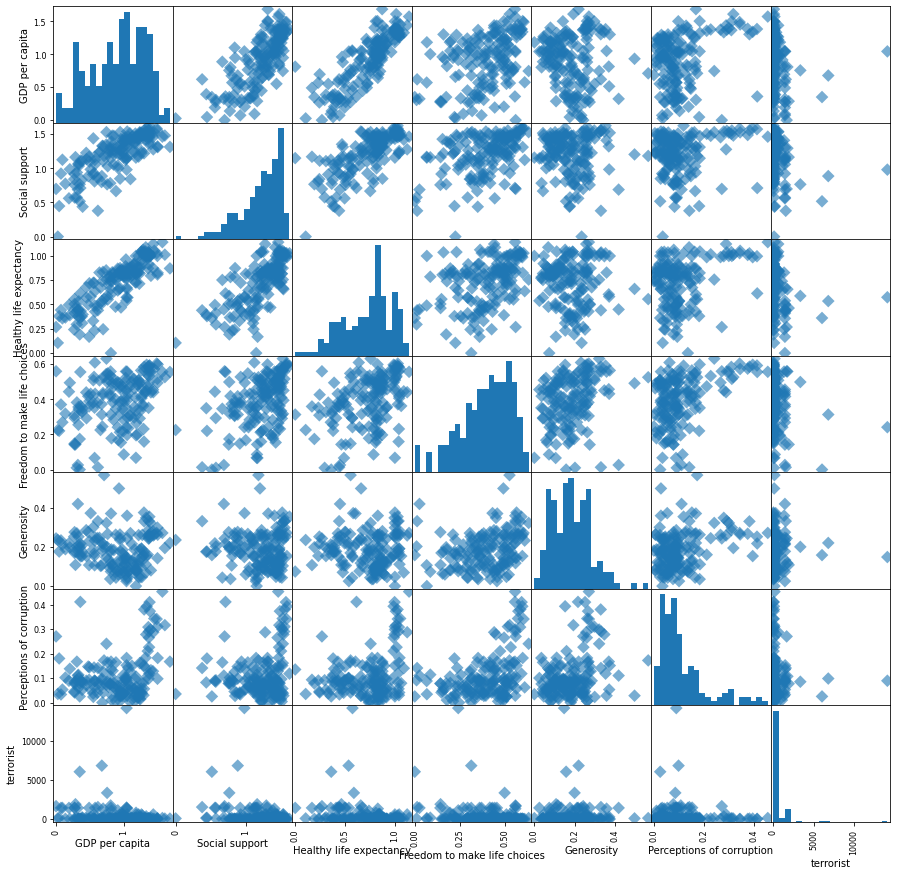

In [ ]:
grr = pd.plotting.scatter_matrix(sub, figsize=(15, 15), marker='D',
hist_kwds={'bins': 20}, s=80, alpha=.6)

The target variable of interest is `Happiness_level`. 

Between `Happiness_level` and the predictor variables `GDP per capita`, `Social Support` and `Healthy life expectancy`, it is clear that higher levels of these predictor variables are associated with higher levels of happiness, on average, whereas lower values of these predictor variables are associated with lower `Happiness_level` values on average. The relationship between `Happiness_level` and `Freedom to make life choices` is similar, but less clear, since both average and low `Happiness_level` seem to associated with the same `Freedom to make life choices` value.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


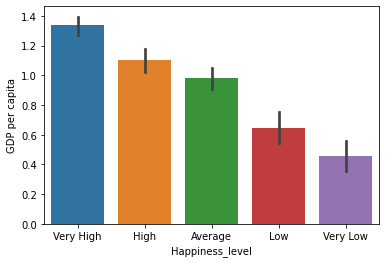

In [ ]:
sns.barplot(data['Happiness_level'], data['GDP per capita'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


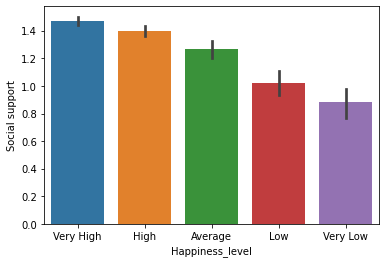

In [ ]:
sns.barplot(data['Happiness_level'], data['Social support'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


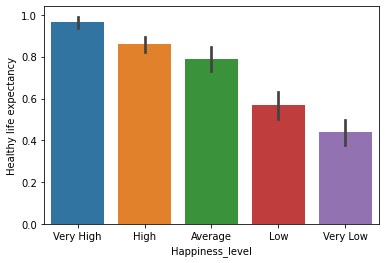

In [ ]:
sns.barplot(data['Happiness_level'], data['Healthy life expectancy'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


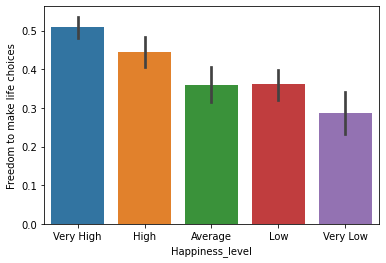

In [ ]:
sns.barplot(data['Happiness_level'], data['Freedom to make life choices'])

The relationship between the target variable `Happiness_level` and the predictor variables `Perceptions of corruption` and `Generosity` are less clear. 

Against expectations, at very high happiness levels, there is on average a high value of `Perceptions of corruption`. However, as a prediction more in one might expect, low or very low `Happiness levels` are associated with higher `Perceptions of corruption` than high or average `Happiness levels`. 

Against expectations, at very low happiness levels, there is on average a high level of `Generosity`. More in line with one's expectations, very high `Happiness_level` is associated with the highest levels of `Generosity`. High, average, or low `Happiness_level`s are associated with comparable levels of `Generosity`, on average.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


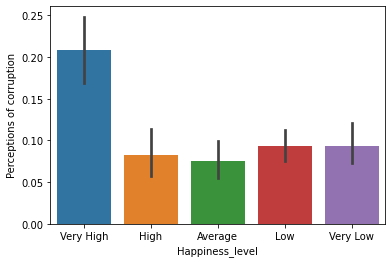

In [ ]:
sns.barplot(data['Happiness_level'], data['Perceptions of corruption'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


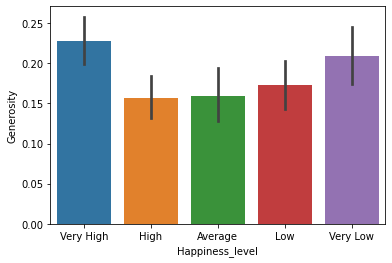

In [ ]:
sns.barplot(data['Happiness_level'], data['Generosity'])

The relationship between `Happiness_level` and `Terrorist_attacks` is less clear too. On average, it seems like those countries that experience the most terrorist attacks, on average, have the lowest levels of happiness. However, the variance in this category of `Happiness_level` is huge. The next highest category of `Happiness_level`, with regard to number of terrorist attacks, is Average -- this is less interpretable, since countries with Very High, High or Low `Happiness_level`s have very low numbers of `Terrorist_attacks`. Without a meaningful ordinal pattern, it will be difficult to explain why countries with Average levels of `Happiness_level` have higher numbers of `Terrorist_attacks`.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


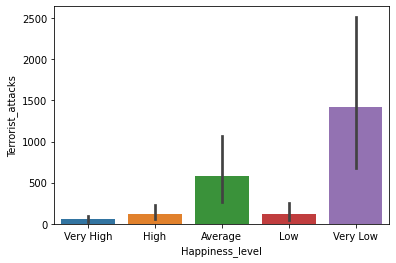

In [ ]:
sns.barplot(data['Happiness_level'], data['Terrorist_attacks'])

There is no even distribution of `Happiness_level`, across `region`. Europe has the most number of countries with very high levels of happiness, and Africa has the most number of countries with low and very low levels of happiness. 

In [ ]:
pd.crosstab(data['Happiness_level'], data['region'])

region,Africa,Americas,Asia,Europe,Oceania
Happiness_level,,,,,
Average,4,2,15,10,0
High,1,12,9,10,0
Low,18,1,10,2,0
Very High,0,7,5,17,2
Very Low,22,1,7,1,0


## Data Preprocessing

In [67]:
X = data.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'], axis=1)
y = data['Happiness_level']

X.shape, y.shape

((156, 8), (156,))

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train.columns.tolist())

(104, 8)
(104,)
['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'region', 'Terrorist_attacks']


In [ ]:
numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [ ]:
def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [68]:
preprocessor(X_train).shape

(104, 12)

In [69]:
pd.get_dummies(y_train).shape

(104, 5)

## Automatic Feature Selection

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 10000))
sel.fit(preprocessor(X_train), pd.get_dummies(y_train))

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000))

In [ ]:
preprocessor(X_train)

#As a result of the Preprocesser, region has been pushed to the back

array([[ 1.16647491,  0.48633461,  0.22247203, ...,  1.        ,
         0.        ,  0.        ],
       [-0.05243526, -1.73341456,  0.0426934 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.24541117, -1.20979789, -1.53350523, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.00143871,  1.06777398,  1.06283257, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.2847101 , -0.25893573,  0.63220006, ...,  1.        ,
         0.        ,  0.        ],
       [-0.55461682, -1.30616906, -0.97744577, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
sel.get_support(indices=True)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False])

Based on this automatic feature selection using a random forest, the first seven numeric variables are important. Region -- dummy coded as 5 indicator variables, was reflected as `False` when `sel.get_support()` was called, and boolean masks were generated. Based on this analysis, Region should be dropped. This was the only categorical predictor; all other numerical predictors were included going forward.

In [ ]:
X_train_new = X_train.iloc[:, 0:6]

X_train_new1 = X_train.iloc[:, -1]

X_train_new['terrorist'] = X_train_new1

In [ ]:
X_test_new = X_test.iloc[:, 0:6]

X_test_new1 = X_test.iloc[:, -1]

X_test_new['terrorist'] = X_test_new1

In [ ]:
X_train_new = numeric_transformer.fit_transform(X_train_new)

In [70]:
X_train_new.shape

(104, 7)

In [ ]:
X_test_new = numeric_transformer.fit_transform(X_test_new)

In [71]:
X_test_new.shape

(52, 7)

In [72]:
pd.get_dummies(y_train).shape

(104, 5)

## Three Prediction Models

### Support Vector Classifier

In [130]:
C = [0.1, 1, 10, 100, 1000]
gamma = [0.1, 1, 10, 100]
kernel = ['linear', 'rbf', 'poly']

In [131]:
param_grid = dict(C=C, gamma=gamma, kernel=kernel)

In [132]:
svc = SVC(random_state = 42)

In [133]:
svc_grid = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 3)

In [134]:
svc_grid.fit(X_train_new, y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly']})

In [135]:
svc_grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [136]:
svc_grid.best_score_

0.6543417366946779

In [137]:
svc_score = svc_grid.score(X_test_new, y_test)
svc_score

0.46153846153846156

### Gradient Boosted Classifier

In [138]:
n_estimators = [x for x in np.arange(1, 100, 9)]
learning_rates = [1, 0.5, 0.1, 0.01]
max_depth = [x for x in np.arange(5, 50, 5)]

In [139]:
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rates,
               'max_depth': max_depth}

In [140]:
gbc = GradientBoostingClassifier(random_state = 42)

In [141]:
gbc_grid = GridSearchCV(estimator = gbc, param_grid = param_grid, cv = 3, verbose = 1)

In [142]:
gbc_grid.fit(X_train_new, y_train)

Fitting 3 folds for each of 396 candidates, totalling 1188 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [1, 0.5, 0.1, 0.01],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45],
                         'n_estimators': [1, 10, 19, 28, 37, 46, 55, 64, 73, 82,
                                          91]},
             verbose=1)

In [143]:
gbc_grid.best_params_

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 55}

In [144]:
gbc_grid.best_score_

0.7016806722689076

In [145]:
gbc_score = gbc_grid.score(X_test_new, y_test)

gbc_score

0.46153846153846156

### Neural Network (Fully-Connected Multilayer Perceptron)

In [107]:
def create_model(hiddennodes=2, number_hidden_layers=2):
  model = Sequential()
  model.add(Dense(hiddennodes, input_dim= 7, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 
  [model.add(Dense(hiddennodes, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) for x in range(number_hidden_layers)]
  model.add(Dense(5, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) 
  return model

In [108]:
kc = KerasClassifier(build_fn = create_model, epochs=100, verbose = 1)

param_grid = dict(hiddennodes=[40, 60, 80], number_hidden_layers = [2, 4, 6])

In [ ]:
kc_grid = GridSearchCV(estimator=kc, param_grid=param_grid)
kc_grid.fit(X_train_new, pd.get_dummies(y_train))

In [110]:
kc_grid.best_params_

{'hiddennodes': 80, 'number_hidden_layers': 2}

In [111]:
kc_grid.best_score_

0.616190493106842

In [112]:
kc_score = kc_grid.score(X_test_new, pd.get_dummies(y_test))

52/52 [==============================] - 3s 63ms/sample - loss: 2.5640 - acc: 0.4423


Adding on l2 regularization for input and hidden layers, and increasing the number of epochs to 1000:

In [125]:
modelimprove = Sequential()
modelimprove.add(Dense(80, input_dim= 7, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 
modelimprove.add(Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
modelimprove.add(Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
modelimprove.add(Dense(5, activation='softmax'))
modelimprove.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [ ]:
modelimprove.fit(X_train_new, pd.get_dummies(y_train), 
               epochs = 1000, callbacks = [es])  

In [205]:
#Helper Code function for model_eval_metrics
def model_eval_metrics(y_true, y_pred):
  accuracy_eval = accuracy_score(y_true, y_pred)
  f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
  precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
  recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
  metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval]}
  finalmetricdata = pd.DataFrame.from_dict(metricdata)
  return finalmetricdata

In [206]:
prediction_index=modelimprove.predict_classes(X_test_new)

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))

modeleval=model_eval_metrics( y_test,predicted_labels)

modeleval

,accuracy,f1_score,precision,recall
0,0.5,0.502731,0.54381,0.513333


In [204]:
kc_score = modeleval.loc[:, 'accuracy'].values

#### Comparing Models

In [200]:
print(f"Support Vector Classifier Test Score is: {svc_score}")
print(f"Gradient Boosted Classifier Test Score is: {gbc_score}")
print(f"Neural Network Keras Classifier Test Score is: {kc_score}")

Support Vector Classifier Test Score is: 0.46153846153846156
Gradient Boosted Classifier Test Score is: 0.46153846153846156
Neural Network Keras Classifier Test Score is: [0.5]


The best model of this brief model experimentation exercise is the Keras Classifier.

#### Best Model

In [201]:
kc_grid.best_params_

{'hiddennodes': 80, 'number_hidden_layers': 2}

The fully connected neural network that was found to be best, through the `GridSearchCV` process, was a neural network with 80 hidden nodes and 2 hidden layers, iterated over 1000 epochs and with L2 regularization at the input and hidden layers.



## Uploading Best Model to AI Model Share

In [ ]:
!pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [154]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

In [155]:
# Save keras model to onnx file

from aimodelshare.aimsonnx import model_to_onnx
# transform keras model to ONNX
onnx_model_keras= model_to_onnx(modelimprove, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 16 -> 12
The maximum opset needed by this model is only 9.


In [156]:
#aimodelshare username and password
username = "kagenlim"
password = #password

# load submit model creds (only gives access to s3 bucket)
# Load from pkl file
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

In [151]:
# test submit_model()
ai.submit_model("onnx_model_keras.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

The preprocessor file at preprocessor.zip does not exist


True

In [157]:
# Check leaderboard
data=ai.get_leaderboard("https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=2)

In [158]:
ai.stylize_leaderboard(data, category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,loss,optimizer,model_config,username,version
0,59.62%,58.16%,65.36%,60.55%,keras,nan,True,Sequential,4.000000,9477.000000,4.000000,str,SGD,"{'name': 'sequential_1', 'laye...",mikedparrott,146
1,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,67
2,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 5, 'break_ties': False, ...",kka2120,90
3,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,94
4,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,96
5,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,131
6,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,110
7,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,125
8,51.92%,52.43%,63.00%,54.00%,keras,nan,True,Sequential,5.000000,15941.000000,5.000000,str,Adam,"{'name': 'sequential_45', 'lay...",dv2438,158
9,51.92%,52.43%,63.00%,54.00%,sklearn,nan,nan,LogisticRegression,nan,45.000000,nan,nan,lbfgs,"{'C': 53.37, 'class_weight': N...",dv2438,157
